## ТЗ
Формально говоря вам предстоит сделать следующее:

1) реализовать следующие алгоритмы машинного обучения: Linear/ Logistic Regression, SVM, KNN, Naive Bayes в отдельных классах 

2)  Данные классы должны наследоваться от BaseEstimator и  ClassifierMixin, иметь методы fit и predict (подробнее: https://scikit-learn.org/stable/developers/develop.html )

3) Вы должны организовать весь процесс предобработки, обучения и тестирования с помощью Pipeline (подробнее: https://scikit-learn.org/stable/modules/compose.html)

4) Вы должны настроить гиперпараметры моделей с помощью кросс валидации (GridSearchCV,RandomSearchCV, подробнее здесь: https://scikit-learn.org/stable/modules/grid_search.html), вывести и сохранить эти гиперпараметры в файл, вместе с обученными моделями

5) Проделать аналогично с коробочными решениями

6) Для каждой модели получить оценки метрик:Confusion Matrix,  Accuracy, Recall, Precision, ROC_AUC curve (подробнее: Hands on machine learning with python and scikit learn chapter 3, mlcourse.ai, https://ml-handbook.ru/chapters/model_evaluation/intro)

7) Проанализировать полученные результаты и сделать выводы о применимости моделей

8) Загрузить полученные гиперпараметры модели и обученные модели в формате pickle  на гит вместе с jupyter notebook ваших экспериментов

# Информация о датасете и некоторые мысли из прошлой ЛР. 

Я решил взять какой-нибудь хороший и простой для понимания датасет с kaggle для задачи классификации. Мой выбор пал на датасет для сердечных заболеваний. (https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) 

В данной задаче нужно будет предсказывать, есть ли у человека проблемы с сердцем (сердечная недостаточность) или нет, т.е. задача бинарной классификации.

Вот информация о признаках из данного датасета, взята из kaggle.

Attribute Information

Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]

**Что нужно сделать с данными (из прошлой ЛР):**

1) Сделать FastingBS категориальной

2) Все категориальные фичи прогнать через OneHotEncoder.

3) В пайплане для модели можно применить нормализацию числовых признаков, а также как-то уменьшить смещение Cholesterol и Oldpeak.

4) Невалидных данных и NaN'ов в датасете не было.

5) Таргет-признак сбалансирован, тут тоже ничего делать не надо. (хотя в процессе обучения можно поиграться с границей, начиная с которой считать человека больным, чтобы случайно не пропустить больного человека)

6) Каких-то серьезных корреляций также замечено не было, так что уменьшить число признаков тут скорее всего не получится.

# Загрузка датасета и его подготовка

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
data = pd.read_csv('gdrive/MyDrive/archive/heart.csv')

In [4]:
# Числовые признаки
num_cols = [
    'Age',
    'RestingBP',
    'Cholesterol',
    'MaxHR',
    'Oldpeak'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'ChestPainType',
    'FastingBS',
    'RestingECG',
    'ExerciseAngina',
    'ST_Slope'
]

feature_cols = num_cols + cat_cols
target_col = 'HeartDisease'

"1) Сделать FastingBS категориальной"

In [5]:
data["FastingBS"] = data["FastingBS"].astype('object')

Так как у меня один файл с данными, то я его разделю на тестовую и тренировочную, а тренировочную буду разделять при помощи кросс-валидации (если не забуду).

In [6]:
X = data.drop(columns=[target_col])
y = data[target_col]
data_train, data_test, target_train, target_test = train_test_split(X.values, y.values, 
                                                                    train_size=0.9,
                                                                    random_state=42,
                                                                    shuffle=True)

# Реализация Linear/ Logistic Regression, SVM, KNN, Naive Bayes в отдельных классах. Использование классов из sklearn. Их сравнение

## Logistic Regression

### Мой класс Logistic Regression

Импортируем некоторые полезные вещи.

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix
import pickle

Чтобы убрать ошибку "TypeError: A sparse matrix was passed, but dense data is required.", пришлось написать(взять со стека) класс ниже.

In [8]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

Класс логистической регрессии.

In [9]:
class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    """
    lr - learning rate
    C - обратный коэф регуляризации (чем меньше C, тем больше штраф)
    bound - граница, начиная с которой объект относится к первому классу
    max_iter - число эпох
    """
    def __init__(self,  
                 lr: float = 1e-2, 
                 C: float = 1.0,
                 batch_size: int = 32, 
                 bound: float = 0.5,
                 max_iter: int = 100):
        self.lr = lr
        self.C = C
        self.batch_size = batch_size
        self.bound = bound
        self.max_iter = max_iter

    @staticmethod
    def sigmoid(v: np.ndarray):
        return 1.0 / (1.0 + np.exp(-v))

    def fit(self, X, y):
         X, y = check_X_y(X, y)
         self.X_ = X
         self.y_ = y

         w = np.random.normal(size=(self.X_.shape[1], ))
         b = 0.0

         for i in range(self.max_iter):
             for batch_start in range(0, len(self.X_), self.batch_size):
                 batch_end = batch_start + self.batch_size
                 batch_X = self.X_[batch_start:batch_end]
                 batch_y = self.y_[batch_start:batch_end]
                 sigmoid_val = MyLogisticRegression.sigmoid(batch_X @ w + b)
                 w -= (self.lr * batch_X.T @ (sigmoid_val - batch_y) + w / self.C) / self.batch_size
                 b -= self.lr * np.sum(sigmoid_val - batch_y) / self.batch_size

         self.w = w
         self.b = b
         return self

    # нужна, чтобы заработал roc_auc scoring
    def decision_function(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return X @ self.w + self.b

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return MyLogisticRegression.sigmoid(X @ self.w + self.b)

    def predict(self, X):
         check_is_fitted(self)
         X = check_array(X)
         sigmoid_val = self.predict_proba(X)
         return np.where(sigmoid_val > self.bound, 1, 0 )

Создадим pipe и при помощи GridSearchCV зададим перебор гиперпараметров по сетке.

In [10]:
cv_num = 5
logreg_prefix = 'mylogisticregression__'

pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    DenseTransformer(),
    PowerTransformer(standardize=True),
    MyLogisticRegression()
)

param_grid = {
    logreg_prefix + "lr": [1e-04, 1e-03, 1e-02],
    logreg_prefix + "batch_size": [32, 64],
    logreg_prefix + "C": [1e-1, 1.0, 10.0]
}
CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="roc_auc",
                        verbose=0,
                        refit=True)

In [11]:
CV_model.fit(data_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('densetransformer',
                                        <__main__.DenseTransformer object at 0x7f8298922350>),
                                       ('powertransformer', PowerTransformer()),
                                       ('mylogisticregression',
                                        MyLogisticRegression())]),
             param_grid={'mylogisticregression__C': [0.1, 1.0, 10.0],
                         'mylogisticregression__batch_size': [32, 64],
                         'mylogisticregression__lr': [0.0001, 0.001, 0.01]},
             scoring='roc_auc')

Посмотрим на лучшие параметры.

In [12]:
CV_model.best_params_

{'mylogisticregression__C': 1.0,
 'mylogisticregression__batch_size': 64,
 'mylogisticregression__lr': 0.0001}

Посмотрим на метрики.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


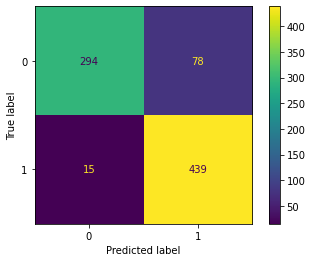

In [13]:
plot_confusion_matrix(CV_model, data_train, target_train) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


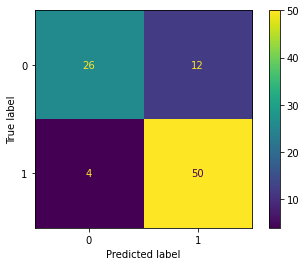

In [14]:
plot_confusion_matrix(CV_model, data_test, target_test) 

In [15]:
recall_score(target_test, CV_model.predict(data_test))

0.9259259259259259

In [16]:
recall_score(target_train, CV_model.predict(data_train))

0.9669603524229075

In [17]:
precision_score(target_test, CV_model.predict(data_test))

0.8064516129032258

In [18]:
precision_score(target_train, CV_model.predict(data_train))

0.8491295938104448

Из метрик видно, что модель имеет precision хуже, чем recall, но так как мы пытаемся предсказывать наличие болезни, то recall в нашем слуачае более важен. (как мера того, сколько больных людей мы нащли из всего числа больных)

In [19]:
accuracy_score(target_test, CV_model.predict(data_test))

0.8260869565217391

In [20]:
accuracy_score(target_train, CV_model.predict(data_train))

0.887409200968523

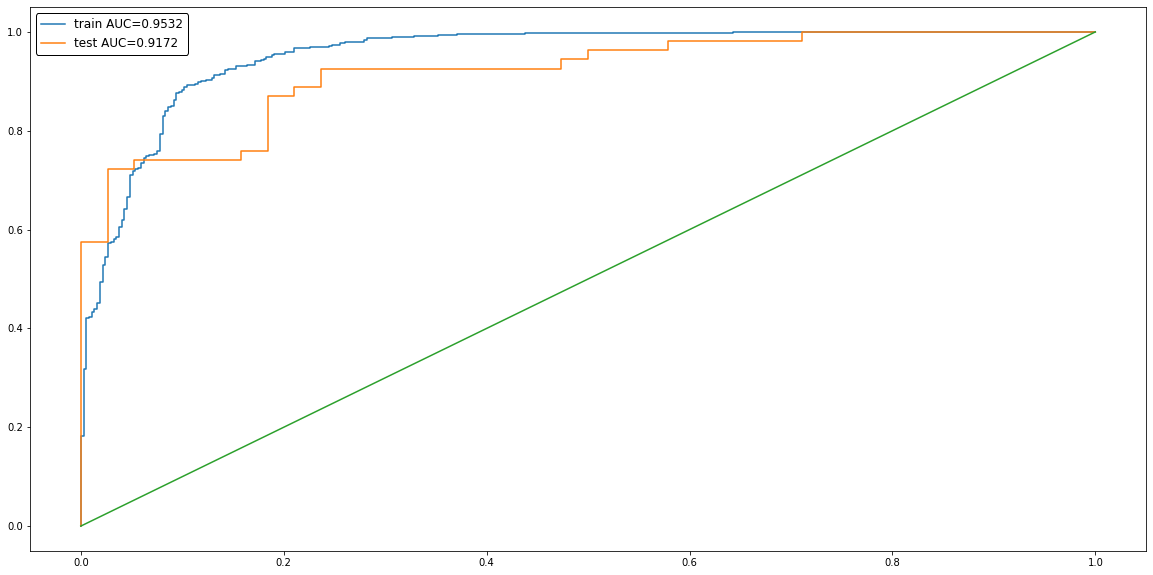

In [21]:
target_train_predicted = CV_model.predict_proba(data_train)
target_test_predicted = CV_model.predict_proba(data_test)

train_auc = roc_auc_score(target_train, target_train_predicted)
test_auc = roc_auc_score(target_test, target_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(target_train, target_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(target_test, target_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Как видно из метрик переобучения нет.

Сохраним модель.

In [22]:
with open('my_logreg.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

### Класс Logistic Regression из коробки

Повторим то же самое для логистической модели из коробки.

In [23]:
cv_num = 5

pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    DenseTransformer(),
    PowerTransformer(standardize=True),
    LogisticRegression()
)

param_grid = {
    "logisticregression__penalty": ["l2"],
    "logisticregression__C": [1e-1, 1.0, 10.0],
    "logisticregression__solver": ["lbfgs", "newton-cg", "sag"],
    "logisticregression__max_iter": [100, 300],
    "logisticregression__tol": [1e-2, 1e-3]
}
CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="roc_auc",
                        verbose=0,
                        refit=True)

In [24]:
CV_model.fit(data_train, target_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('densetransformer',
                                        <__main__.DenseTransformer object at 0x7f8295ae1d10>),
                                       ('powertransformer', PowerTransformer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.1, 1.0, 10.0],
                         'logisticregression__max_iter': [100, 300],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['lbfgs', 'newton-cg',
                                                        'sag'],
                         'logisticregression__tol': [0.01, 0.001]},
             scoring='roc_auc')

Посмотрим на лучшие параметры.

In [25]:
CV_model.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__max_iter': 300,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'sag',
 'logisticregression__tol': 0.01}

Посмотрим на метрики.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


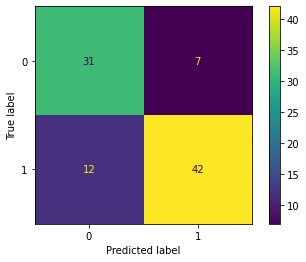

In [26]:
plot_confusion_matrix(CV_model, data_test, target_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


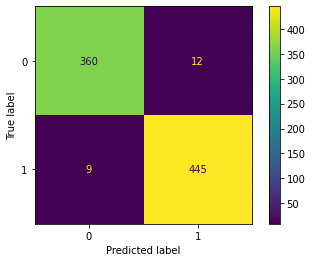

In [27]:
plot_confusion_matrix(CV_model, data_train, target_train) 

In [28]:
recall_score(target_test, CV_model.predict(data_test))

0.7777777777777778

In [29]:
recall_score(target_train, CV_model.predict(data_train))

0.9801762114537445

In [30]:
precision_score(target_test, CV_model.predict(data_test))

0.8571428571428571

In [31]:
precision_score(target_train, CV_model.predict(data_train))

0.973741794310722

In [32]:
accuracy_score(target_test, CV_model.predict(data_test))

0.7934782608695652

In [33]:
accuracy_score(target_train, CV_model.predict(data_train))

0.9745762711864406

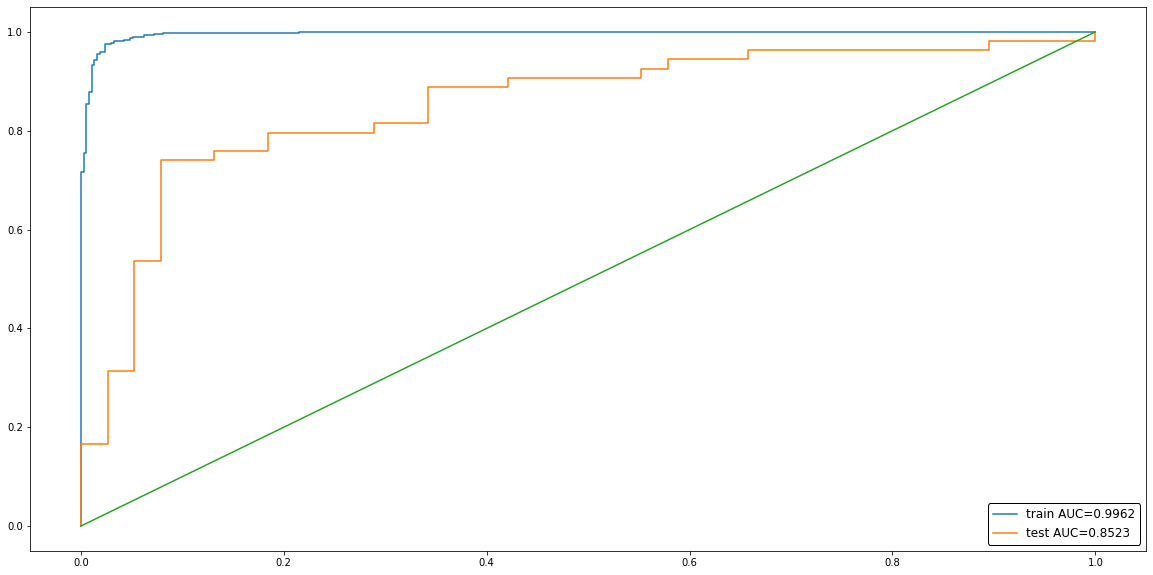

In [34]:
target_train_predicted = CV_model.predict_proba(data_train)[:, 1]
target_test_predicted = CV_model.predict_proba(data_test)[:, 1]

train_auc = roc_auc_score(target_train, target_train_predicted)
test_auc = roc_auc_score(target_test, target_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(target_train, target_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(target_test, target_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

На модели из коробки видно переобучение, также можно заметить, что recall < precision, что, как я писал выше, не очень хорошо для нашей задачи. 

Сохраним модель.

In [35]:
with open('sklearn_logreg.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

По итогу оказалось, что самописная модель показала себя лучше

## Naive Bayes

### Мой класс Naive Bayes

Напишем класс NaiveBayes. Будем продполагать, что все признаки имеют нормальное распределение, а также все признаки независимы.

In [36]:
from scipy.stats import norm

In [37]:
class MyNaiveBayes(BaseEstimator, ClassifierMixin):
    # Bayes th: P(y=C|X) == P(X|y=C)P(y=C) / P(X)
    # возьмем логарифм от формулы, чтобы избежать взрыва экспоненты
    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self.unique_labels = np.unique(y)
        self.X_ = X
        self.y_ = y    
        self.smooth = 1e-3 

        # Считаем P(X|y=C) для каждого признака и каждой метки класса
        self.X_depends_on_Y = {} 
        for label in self.unique_labels:
            distributions = []
            for i in range(X.shape[1]):
                feature = X[y == label, i].flatten()
                # считаем среднне и дисперсию и добавляем нормальное распределение
                distributions.append(norm(loc=feature.mean(), scale=(feature.std() + self.smooth)))
            self.X_depends_on_Y[label] = distributions

        # Считаем P(y=C), как выборочную вероятность
        self.Y_probs = {label: sum((y == label)).astype(float) / len(y) for label in self.unique_labels}
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        probs = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        X_probs = np.ones((X.shape[0], len(self.unique_labels)), dtype=float)

        # Считаем числитель формулы Байеса
        for i, label in enumerate(self.unique_labels):
            for j in range(X.shape[1]):
                probs[:, i] += np.log(self.X_depends_on_Y[label][j].pdf(X[:, j]) + self.smooth)
            probs[:, i] += np.log(self.Y_probs[label] + self.smooth)

        # Я решил не делить на знаменатель формулы, так как у меня на этом моменте все почему-то ломалось,
        # и классификатор всегда предсказывал 0-ой класс + случались переполнения в произведении
        # так хоть работает, но метода predict_proba нет, поэтому не заработала roc_auc_score

        # Деление на P(X) по факту не влияет на ответ, только делает из числа вероятность

        return np.array(probs.argmax(axis=1))  

Также создадим pipe и обучим модель, используя кросс-валидацию.

In [38]:
cv_num = 5

pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    DenseTransformer(),
    PowerTransformer(standardize=False),
    MyNaiveBayes()
)

param_grid = dict()

CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="accuracy",
                        verbose=0,
                        refit=True)

In [39]:
CV_model.fit(data_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('densetransformer',
                                        <__main__.DenseTransformer object at 0x7f829580e4d0>),
                                       ('powertransformer',
                                        PowerTransformer(standardize=False)),
                                       ('mynaivebayes', MyNaiveBayes())]),
             param_grid={}, scoring='accuracy')

Посморим на метрики

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


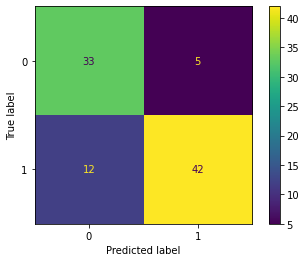

In [40]:
plot_confusion_matrix(CV_model, data_test, target_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


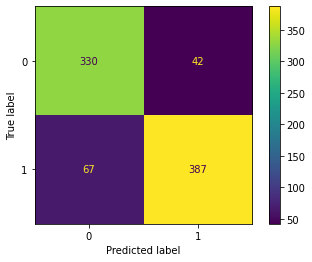

In [41]:
plot_confusion_matrix(CV_model, data_train, target_train) 

In [42]:
recall_score(target_test, CV_model.predict(data_test))

0.7777777777777778

In [43]:
recall_score(target_train, CV_model.predict(data_train))

0.8524229074889867

In [44]:
precision_score(target_test, CV_model.predict(data_test))

0.8936170212765957

In [45]:
precision_score(target_train, CV_model.predict(data_train))

0.9020979020979021

Precision > recall, что опять же не очень хорошо в рамках нашей задачи.

In [46]:
accuracy_score(target_train, CV_model.predict(data_train))

0.8680387409200968

In [47]:
accuracy_score(target_test, CV_model.predict(data_test))

0.8152173913043478

Судя по метрикам переобучения нет. 

In [48]:
with open('my_nb.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

### Класс NaiveBayes из коробки

In [49]:
from sklearn.naive_bayes import GaussianNB

In [50]:
cv_num = 5

pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    DenseTransformer(),
    PowerTransformer(standardize=False),
    GaussianNB()
)

param_grid = dict()
CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="accuracy",
                        verbose=0,
                        refit=True)

In [51]:
CV_model.fit(data_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('densetransformer',
                                        <__main__.DenseTransformer object at 0x7f8294e20b90>),
                                       ('powertransformer',
                                        PowerTransformer(standardize=False)),
                                       ('gaussiannb', GaussianNB())]),
             param_grid={}, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


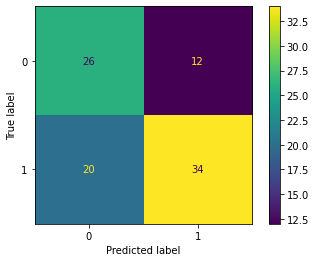

In [52]:
plot_confusion_matrix(CV_model, data_test, target_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


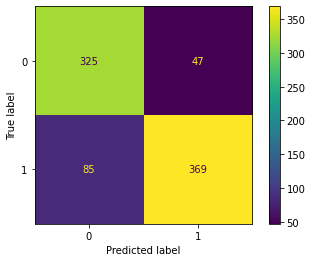

In [53]:
plot_confusion_matrix(CV_model, data_train, target_train) 

In [54]:
recall_score(target_test, CV_model.predict(data_test))

0.6296296296296297

In [55]:
recall_score(target_train, CV_model.predict(data_train))

0.8127753303964758

In [56]:
precision_score(target_test, CV_model.predict(data_test))

0.7391304347826086

In [57]:
precision_score(target_train, CV_model.predict(data_train))

0.8870192307692307

In [58]:
accuracy_score(target_test, CV_model.predict(data_test))

0.6521739130434783

In [59]:
accuracy_score(target_train, CV_model.predict(data_train))

0.8401937046004843

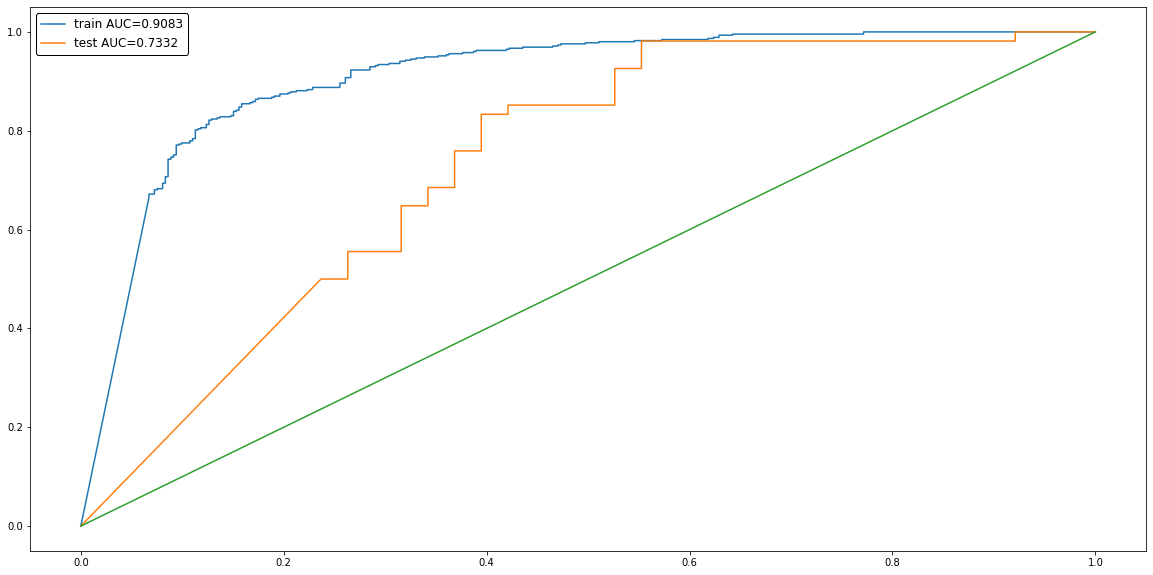

In [60]:
target_train_predicted = CV_model.predict_proba(data_train)[:, 1]
target_test_predicted = CV_model.predict_proba(data_test)[:, 1]

train_auc = roc_auc_score(target_train, target_train_predicted)
test_auc = roc_auc_score(target_test, target_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(target_train, target_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(target_test, target_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [61]:
with open('sklearn_nb.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

Как видно из результатов для моего NaiveBayes и NaiveBayes из коробки, эта модель хуже себя показала, по сравнению с LogisticRegression, что логично, так как далеко не все признаки имеют нормальное распределение (даже PowerTransformer не помог это исправить) + не все признаки независимы.

## kNN

### Мой kNN

In [115]:
class MyKNN(BaseEstimator, ClassifierMixin):
    """
    nn - число соседей
    w - схема подсчета весов
    """
    def __init__(self,  
                 nn: int = 5,
                 w: str = "uniform"):
        self.nn = nn
        self.w = w

    def fit(self, X, y):
         X, y = check_X_y(X, y)
         self.X_ = X
         self.y_ = y
         self.unique_labels = np.unique(y)
         return self

    def get_pred(self, nearest):
        preds = np.zeros(len(self.unique_labels))
        for d, i in nearest:
            if self.w == "distance":
                preds[i] += 1.0 / (d + 1e-08)
            else:
                preds[i] += 1
        return np.argmax(preds)

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        preds = []
        for obj in X:
            dists = []
            for i, obj_to_cmp in enumerate(self.X_):
                dist = np.linalg.norm(obj - obj_to_cmp)
                dists.append((dist, self.y_[i]))
            dists.sort()
            nearest = dists[: self.nn]
            preds.append(self.get_pred(nearest))

        return np.array(preds, dtype=int)

In [116]:
cv_num = 5
logreg_prefix = 'myknn__'

pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    DenseTransformer(),
    PowerTransformer(standardize=True),
    MyKNN()
)

param_grid = {
    logreg_prefix + "nn": [3, 5, 7],
    logreg_prefix + "w": ["uniform", "distance"]
}
CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="accuracy",
                        verbose=0,
                        refit=True)

In [117]:
CV_model.fit(data_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('densetransformer',
                                        <__main__.DenseTransformer object at 0x7f829280ed50>),
                                       ('powertransformer', PowerTransformer()),
                                       ('myknn', MyKNN())]),
             param_grid={'myknn__nn': [3, 5, 7],
                         'myknn__w': ['uniform', 'distance']},
             scoring='accuracy')

In [118]:
CV_model.best_params_

{'myknn__nn': 5, 'myknn__w': 'distance'}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


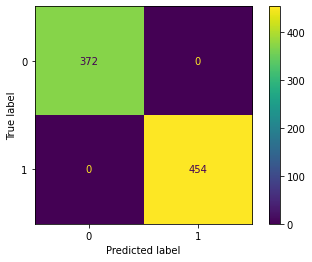

In [119]:
plot_confusion_matrix(CV_model, data_train, target_train) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


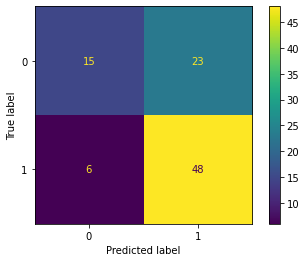

In [120]:
plot_confusion_matrix(CV_model, data_test, target_test) 

In [121]:
recall_score(target_test, CV_model.predict(data_test))

0.8888888888888888

In [122]:
recall_score(target_train, CV_model.predict(data_train))

1.0

In [123]:
precision_score(target_test, CV_model.predict(data_test))

0.676056338028169

In [124]:
precision_score(target_train, CV_model.predict(data_train))

1.0

In [125]:
accuracy_score(target_test, CV_model.predict(data_test))

0.6847826086956522

In [126]:
accuracy_score(target_train, CV_model.predict(data_train))

1.0

In [127]:
with open('my_knn.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

### kNN из коробки

In [128]:
from sklearn.neighbors import KNeighborsClassifier

In [129]:
cv_num = 5

pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    DenseTransformer(),
    PowerTransformer(standardize=True),
    KNeighborsClassifier()
)

param_grid = {
    "kneighborsclassifier__n_neighbors": [3, 5, 7],
    "kneighborsclassifier__weights": ["uniform", "distance"]
}
CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="accuracy",
                        verbose=0,
                        refit=True)

In [130]:
CV_model.fit(data_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('densetransformer',
                                        <__main__.DenseTransformer object at 0x7f8292e07110>),
                                       ('powertransformer', PowerTransformer()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy')

In [131]:
CV_model.best_params_

{'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__weights': 'distance'}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


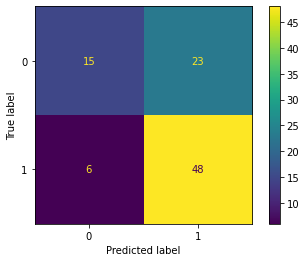

In [132]:
plot_confusion_matrix(CV_model, data_test, target_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


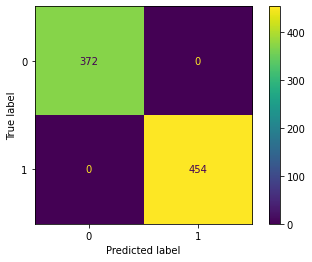

In [133]:
plot_confusion_matrix(CV_model, data_train, target_train) 

In [134]:
recall_score(target_test, CV_model.predict(data_test))

0.8888888888888888

In [135]:
recall_score(target_train, CV_model.predict(data_train))

1.0

In [136]:
precision_score(target_test, CV_model.predict(data_test))

0.676056338028169

In [137]:
precision_score(target_train, CV_model.predict(data_train))

1.0

In [138]:
accuracy_score(target_test, CV_model.predict(data_test))

0.6847826086956522

In [139]:
accuracy_score(target_train, CV_model.predict(data_train))

1.0

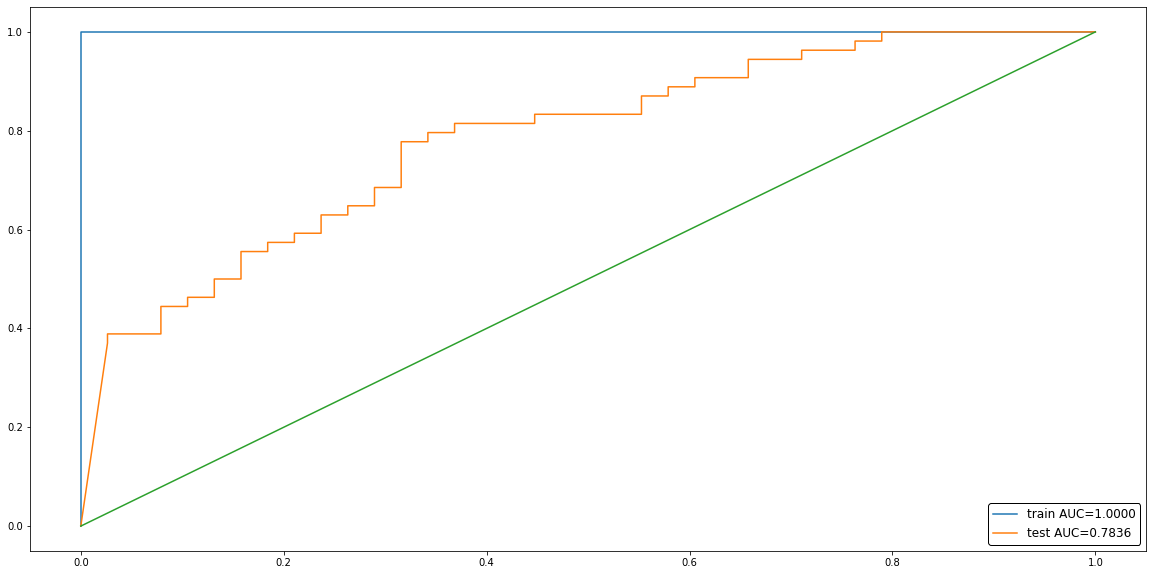

In [140]:
target_train_predicted = CV_model.predict_proba(data_train)[:, 1]
target_test_predicted = CV_model.predict_proba(data_test)[:, 1]

train_auc = roc_auc_score(target_train, target_train_predicted)
test_auc = roc_auc_score(target_test, target_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(target_train, target_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(target_test, target_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [141]:
with open('sklearn_knn.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

## SVM

### Мой SVM

In [214]:
class MySVM(BaseEstimator, ClassifierMixin):
    """
    lr - learning rate
    C - обратный коэф регуляризации (чем меньше C, тем больше штраф)
    kernel - ядро svm
    """
    def __init__(self,  
                 lr: float = 1e-3,
                 C: float = 1.0,
                 max_iter: int = 100):
        self.C = C
        self.lr = lr
        self.max_iter = max_iter

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.labels = np.where(y == 0, -1, 1)

        w = np.random.normal(size=(self.X_.shape[1], ))
        b = 0.0

        for _ in range(self.max_iter):
            for i, obj in enumerate(self.X_):
                if self.labels[i] * (obj @ w + b) >= 1:
                    dw = w / self.C
                    db = 0
                else:
                    dw = w / self.C - self.labels[i] * obj
                    db = -self.labels[i]
                w -= self.lr * dw
                b -= self.lr * db

        self.w = w
        self.b = b
        return self

    def predict(self, X):
        return np.where(np.sign(np.dot(X, self.w) + self.b) == -1, 0, 1)

In [215]:
cv_num = 5
logreg_prefix = 'mysvm__'

pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    DenseTransformer(),
    PowerTransformer(standardize=True),
    MySVM()
)

param_grid = {
    logreg_prefix + "lr": [1e-04, 1e-03, 1e-02],
    logreg_prefix + "C": [1e-1, 1.0, 10.0]
}
CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="accuracy",
                        verbose=0,
                        refit=True)

In [216]:
CV_model.fit(data_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('densetransformer',
                                        <__main__.DenseTransformer object at 0x7f8291eeff50>),
                                       ('powertransformer', PowerTransformer()),
                                       ('mysvm', MySVM())]),
             param_grid={'mysvm__C': [0.1, 1.0, 10.0],
                         'mysvm__lr': [0.0001, 0.001, 0.01]},
             scoring='accuracy')

In [217]:
CV_model.best_params_

{'mysvm__C': 1.0, 'mysvm__lr': 0.0001}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


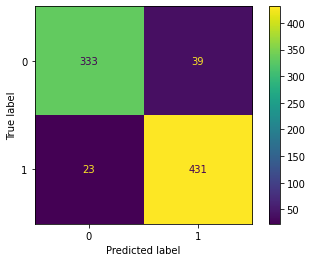

In [218]:
plot_confusion_matrix(CV_model, data_train, target_train) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


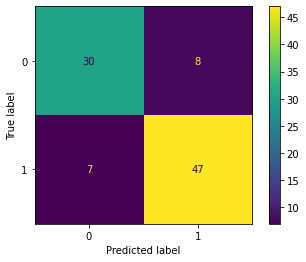

In [219]:
plot_confusion_matrix(CV_model, data_test, target_test) 

In [220]:
recall_score(target_test, CV_model.predict(data_test))

0.8703703703703703

In [221]:
recall_score(target_train, CV_model.predict(data_train))

0.9493392070484582

In [222]:
precision_score(target_test, CV_model.predict(data_test))

0.8545454545454545

In [223]:
precision_score(target_train, CV_model.predict(data_train))

0.9170212765957447

In [224]:
accuracy_score(target_test, CV_model.predict(data_test))

0.8369565217391305

In [225]:
accuracy_score(target_train, CV_model.predict(data_train))

0.9249394673123487

In [226]:
with open('my_svm.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

### SVM из коробки

In [174]:
from sklearn.svm import SVC

In [175]:
cv_num = 5

pipe = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    DenseTransformer(),
    PowerTransformer(standardize=True),
    SVC()
)

param_grid = {
    "svc__C": [0.02, 0.1, 0.5],
    "svc__kernel": ["linear", "poly", "rbf"],
    "svc__tol": [1e-2, 5e-2]
}
CV_model = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=cv_num,
                        scoring="accuracy",
                        verbose=0,
                        refit=True)

In [176]:
CV_model.fit(data_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('densetransformer',
                                        <__main__.DenseTransformer object at 0x7f82922f7250>),
                                       ('powertransformer', PowerTransformer()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.02, 0.1, 0.5],
                         'svc__kernel': ['linear', 'poly', 'rbf'],
                         'svc__tol': [0.01, 0.05]},
             scoring='accuracy')

In [177]:
CV_model.best_params_

{'svc__C': 0.5, 'svc__kernel': 'rbf', 'svc__tol': 0.01}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


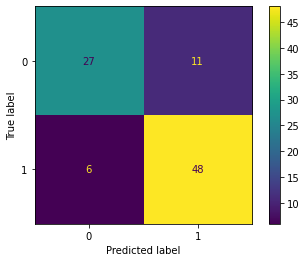

In [178]:
plot_confusion_matrix(CV_model, data_test, target_test) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


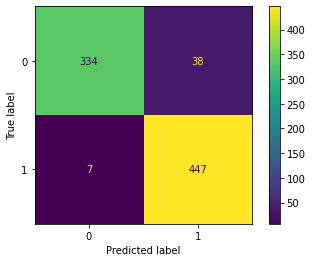

In [179]:
plot_confusion_matrix(CV_model, data_train, target_train) 

In [180]:
recall_score(target_test, CV_model.predict(data_test))

0.8888888888888888

In [181]:
recall_score(target_train, CV_model.predict(data_train))

0.9845814977973568

In [182]:
precision_score(target_test, CV_model.predict(data_test))

0.8135593220338984

In [183]:
precision_score(target_train, CV_model.predict(data_train))

0.9216494845360824

In [184]:
accuracy_score(target_test, CV_model.predict(data_test))

0.8152173913043478

In [185]:
accuracy_score(target_train, CV_model.predict(data_train))

0.9455205811138014

In [186]:
with open('sklearn_svm.pkl', 'wb') as f:
    pickle.dump(CV_model.best_estimator_, f)

# Вывод

Как показали результаты, ручные реализации базовых классификаторов не сильно хуже тех, что есть в sklearn (а некоторые показали себя даже лучше). Линейные модели (логистическая регрессия и линейный SVM) на данном наборе показали себя хорошо. Нелинейный SVM показал себя тоже хорошо, но не сильно лучше линейных моделей. Хуже же всего себя показали kNN и Naive Bayes. kNN даже при небольшом числе соседей быстро переобучился, получив accuracy = 1 на тренировочной выборке, а Naive Bayes просто плохо подошел под задачу в силу своих допущений.